In [1]:
import os
import sys
import importlib
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
project_path = 'C:\\Users\\danny\\Documents_Local\\Caltech_2023-2024\\CS101'

def join_path(relative_path: str) -> str:
    return os.path.join(project_path, relative_path)

def pickle_load(relative_path: str):  # -> pickled_file_contents
    return pickle.load(open(join_path(relative_path), 'rb'))

def pickle_save(obj: object, relative_path: str) -> None:
    pickle.dump(obj, open(join_path(relative_path), 'wb'))

In [3]:
sys.path.append(join_path('EMIT-ECOSTRESS\\modules'))
import datasets.Datasets
import models.Feedforward
import utils.train
import utils.eval

In [4]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

In [19]:
base_data_path = 'Data\\Dataset'
# log_file_path = join_path(r'Miscellaneous\small_nn_benchmark_log.txt')
log_file_path = join_path(r'Miscellaneous\AE_linear_benchmark_log.txt')

# load data

emit_train = pickle_load(
    # os.path.join(base_data_path, 'reflectance_train_pca244.pkl')
    os.path.join(base_data_path, 'AE\\dim_16_train.pkl')
)
emit_val = pickle_load(
    # os.path.join(base_data_path, 'reflectance_val_pca244.pkl')
    os.path.join(
        base_data_path, 'AE\\dim_16_val.pkl'
    )
)

elev_train = pickle_load(
    os.path.join(base_data_path, 'Splits\\elevation_train.pkl')
)
elev_val = pickle_load(
    os.path.join(base_data_path, 'Splits\\elevation_val.pkl')
)

elev_train = (
    (
        elev_train - np.mean(np.concatenate([elev_train, elev_val], axis=1))
    ) / 
    np.std(np.concatenate([elev_train, elev_val], axis=1))
)
elev_val = (
    (
        elev_val - np.mean(np.concatenate([elev_train, elev_val], axis=1))
    ) / 
    np.std(np.concatenate([elev_train, elev_val], axis=1))
)
eco_train = pickle_load(os.path.join(base_data_path, 'Splits\\temp_train.pkl'))
eco_val = pickle_load(os.path.join(base_data_path, 'Splits\\temp_val.pkl'))

In [20]:
benchmark_combos = [
    (1, 16), (2, 16), (3, 16), (5, 16), (6, 16), (8, 16),
    (10, 16), (12, 16), (16, 16),
]

# benchmark_combos = [
    # (0, 0), (0, 1),
    # (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 8),
    # # (0, 10), (0, 12), (0, 16), (0, 24), (0, 32), (0, 48), (0, 64),
    # # (0, 96), (0, 128), (0, 244),
    # (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8),# (1, 16), (1, 32), (1, 48), (1, 64),
    # (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8),# (2, 16), (2, 32), (2, 48),
    # (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8),# (3, 16), (3, 32), (3, 48),
    # (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8),# (4, 16), (4, 32), (4, 48),
    # (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8),# (5, 16), (5, 32), (5, 48),
    # (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8),# (6, 16), (6, 32),
    # # (7, 2), (7, 4), (7, 8),# (7, 16),
    # (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8),# (8, 16),
    # (9, 2), (9, 4), (9, 8),
    # (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (10, 8),
    # # # (11, 2), (11, 4), (11, 6),
    # (12, 2), (12, 3), (12, 4), (12, 5), (12, 6), (12, 7), (12, 8),
    # # # (13, 2), (13, 3), (13, 4), (13, 5),
    # (14, 2), (14, 3), (14, 4), (14, 5),
    # # # (15, 2), (15, 3), (15, 4), (15, 5),
    # (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (16, 8),
    # # # (17, 2), (17, 3), (17, 4), (17, 5),
    # (18, 2), (18, 3), (18, 4), (18, 5), (18, 6),
    # # # (19, 2), (19, 3), (19, 4), (19, 5),
    # (20, 2), (20, 3), (20, 4), (20, 5), (20, 6),
    # # # (21, 2), (21, 3), (21, 4), (21, 5),
    # (22, 2), (22, 3), (22, 4), (22, 5), (22, 6),
    # # # (23, 2), (23, 3), (23, 4), (23, 5),
    # (24, 2), (24, 3), (24, 4), (24, 5), (24, 6),
    # (32, 2), (32, 3), (32, 4),# (32, 5),
    # (13, 6), (14, 6), (15, 6), (16, 6), (18, 6), (20, 6), (22, 6), (24, 6),# (30, 8), (32, 8),
# ]

# benchmark_combos = [
#     (6, 4),
#     (6, 8),
#     (10, 2),
#     (10, 4),
#     (10, 8),
#     (12, 2),
#     (12, 3),
#     (12, 6),
#     (14, 3),
#     (16, 2),
#     (16, 3),
#     (16, 4),
#     (18, 3),
#     (18, 5),
#     (20, 2),
#     (22, 2),
# ]

len(benchmark_combos)

9

radius=1, n_components=16
 LinearModel(
  (linear_output): Linear(in_features=153, out_features=1, bias=True)
)
Epoch 000:     Train (RMSE, K):  1.0803,  3.2045   	 Val (RMSE, K):  0.93747,  2.5128   	LR:  0.001	Time: 28.0
Epoch 001:     Train (RMSE, K):  0.58806,  1.7443   	 Val (RMSE, K):  0.67978,  1.8221   	LR:  0.001	Time: 28.8
Epoch 002:     Train (RMSE, K):  0.53779,  1.5952   	 Val (RMSE, K):  0.70326,   1.885   	LR:  0.001	Time: 28.7
Epoch 003:     Train (RMSE, K):  0.53235,  1.5791   	 Val (RMSE, K):  0.68081,  1.8249   	LR:  0.001	Time: 28.7
Epoch 004:     Train (RMSE, K):  0.52929,    1.57   	 Val (RMSE, K):  0.69035,  1.8504   	LR:  0.001	Time: 28.5
Epoch 005:     Train (RMSE, K):  0.52758,  1.5649   	 Val (RMSE, K):  0.70162,  1.8806   	LR: 0.0002	Time: 29.0


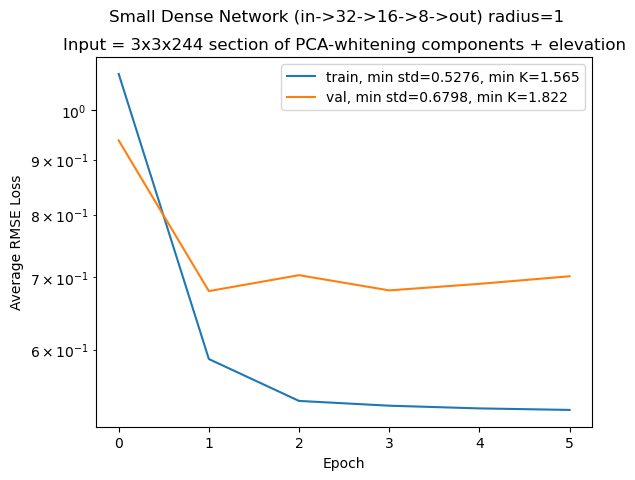

radius=2, n_components=16
 LinearModel(
  (linear_output): Linear(in_features=425, out_features=1, bias=True)
)
Epoch 000:     Train (RMSE, K):  1.1363,  3.3707   	 Val (RMSE, K):  0.98007,   2.627   	LR:  0.001	Time: 31.8
Epoch 001:     Train (RMSE, K):  0.53769,  1.5949   	 Val (RMSE, K):  0.62544,  1.6764   	LR:  0.001	Time: 32.9
Epoch 002:     Train (RMSE, K):  0.50247,  1.4905   	 Val (RMSE, K):  0.63269,  1.6959   	LR:  0.001	Time: 31.6
Epoch 003:     Train (RMSE, K):  0.49824,  1.4779   	 Val (RMSE, K):  0.64529,  1.7296   	LR:  0.001	Time: 33.0
Epoch 004:     Train (RMSE, K):  0.4965,  1.4727   	 Val (RMSE, K):  0.63763,  1.7091   	LR:  0.001	Time: 32.3
Epoch 005:     Train (RMSE, K):  0.49482,  1.4678   	 Val (RMSE, K):  0.64767,   1.736   	LR: 0.0002	Time: 32.4


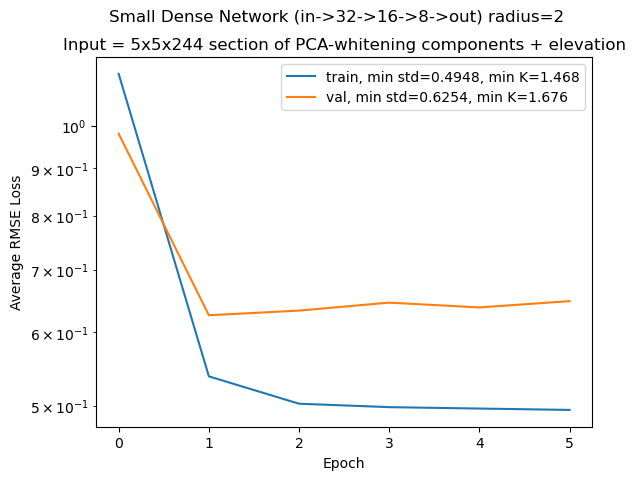

radius=3, n_components=16
 LinearModel(
  (linear_output): Linear(in_features=833, out_features=1, bias=True)
)
Epoch 000:     Train (RMSE, K):  0.99433,  2.9494   	 Val (RMSE, K):  0.8832,  2.3674   	LR:  0.001	Time: 35.9
Epoch 001:     Train (RMSE, K):  0.50854,  1.5084   	 Val (RMSE, K):  0.63306,  1.6969   	LR:  0.001	Time: 36.6
Epoch 002:     Train (RMSE, K):  0.4854,  1.4398   	 Val (RMSE, K):  0.63384,   1.699   	LR:  0.001	Time: 36.8
Epoch 003:     Train (RMSE, K):  0.48309,  1.4329   	 Val (RMSE, K):  0.64598,  1.7315   	LR:  0.001	Time: 37.1
Epoch 004:     Train (RMSE, K):  0.48185,  1.4293   	 Val (RMSE, K):  0.65133,  1.7458   	LR:  0.001	Time: 37.0
Epoch 005:     Train (RMSE, K):  0.47928,  1.4216   	 Val (RMSE, K):  0.6302,  1.6892   	LR: 0.0002	Time: 38.1


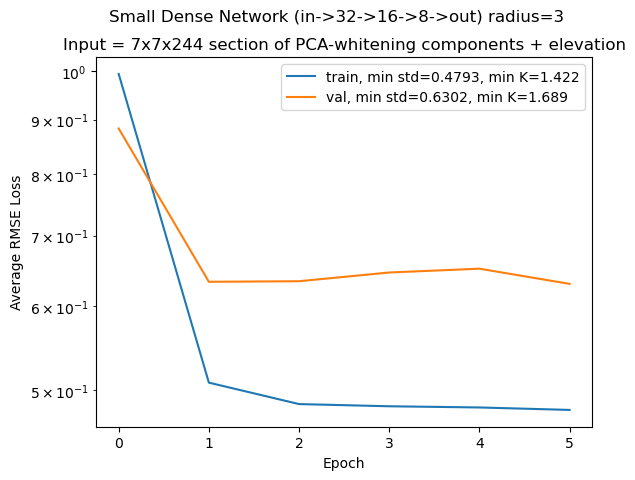

radius=5, n_components=16
 LinearModel(
  (linear_output): Linear(in_features=2057, out_features=1, bias=True)
)
Epoch 000:     Train (RMSE, K):  1.0529,  3.1231   	 Val (RMSE, K):  0.92029,  2.4668   	LR:  0.001	Time: 47.1
Epoch 001:     Train (RMSE, K):  0.49129,  1.4573   	 Val (RMSE, K):  0.6248,  1.6747   	LR:  0.001	Time: 47.4
Epoch 002:     Train (RMSE, K):  0.47272,  1.4022   	 Val (RMSE, K):  0.62732,  1.6815   	LR:  0.001	Time: 47.3
Epoch 003:     Train (RMSE, K):  0.47018,  1.3947   	 Val (RMSE, K):  0.64525,  1.7295   	LR:  0.001	Time: 47.3
Epoch 004:     Train (RMSE, K):  0.46957,  1.3929   	 Val (RMSE, K):  0.64257,  1.7224   	LR:  0.001	Time: 47.2
Epoch 005:     Train (RMSE, K):  0.46508,  1.3795   	 Val (RMSE, K):  0.64422,  1.7268   	LR: 0.0002	Time: 47.1


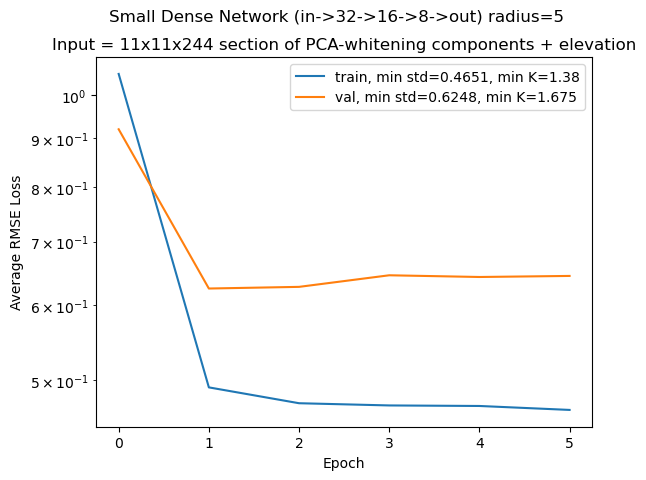

radius=6, n_components=16
 LinearModel(
  (linear_output): Linear(in_features=2873, out_features=1, bias=True)
)
Epoch 000:     Train (RMSE, K):   1.003,   2.975   	 Val (RMSE, K):  0.96951,  2.5987   	LR:  0.001	Time: 52.3
Epoch 001:     Train (RMSE, K):  0.48717,   1.445   	 Val (RMSE, K):  0.65315,  1.7507   	LR:  0.001	Time: 54.3
Epoch 002:     Train (RMSE, K):  0.47013,  1.3945   	 Val (RMSE, K):  0.68353,  1.8321   	LR:  0.001	Time: 53.9
Epoch 003:     Train (RMSE, K):  0.46795,  1.3881   	 Val (RMSE, K):  0.64852,  1.7383   	LR:  0.001	Time: 54.4
Epoch 004:     Train (RMSE, K):  0.46643,  1.3835   	 Val (RMSE, K):  0.64889,  1.7393   	LR:  0.001	Time: 54.0
Epoch 005:     Train (RMSE, K):  0.46691,   1.385   	 Val (RMSE, K):  0.66196,  1.7743   	LR:  0.001	Time: 54.5


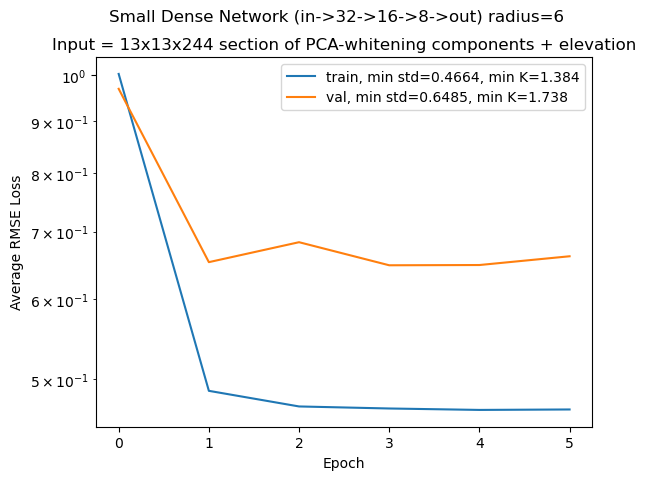

radius=8, n_components=16
 LinearModel(
  (linear_output): Linear(in_features=4913, out_features=1, bias=True)
)
Epoch 000:     Train (RMSE, K):  1.0477,  3.1078   	 Val (RMSE, K):  0.92114,   2.469   	LR:  0.001	Time: 99.0
Epoch 001:     Train (RMSE, K):  0.48745,  1.4459   	 Val (RMSE, K):  0.66675,  1.7872   	LR:  0.001	Time: 99.5
Epoch 002:     Train (RMSE, K):  0.46745,  1.3866   	 Val (RMSE, K):  0.62883,  1.6855   	LR:  0.001	Time: 99.8
Epoch 003:     Train (RMSE, K):  0.46368,  1.3754   	 Val (RMSE, K):  0.71733,  1.9228   	LR:  0.001	Time: 99.5
Epoch 004:     Train (RMSE, K):  0.46354,   1.375   	 Val (RMSE, K):  0.68905,   1.847   	LR:  0.001	Time: 1e+02
Epoch 005:     Train (RMSE, K):  0.46185,    1.37   	 Val (RMSE, K):  0.65442,  1.7541   	LR:  0.001	Time: 99.2


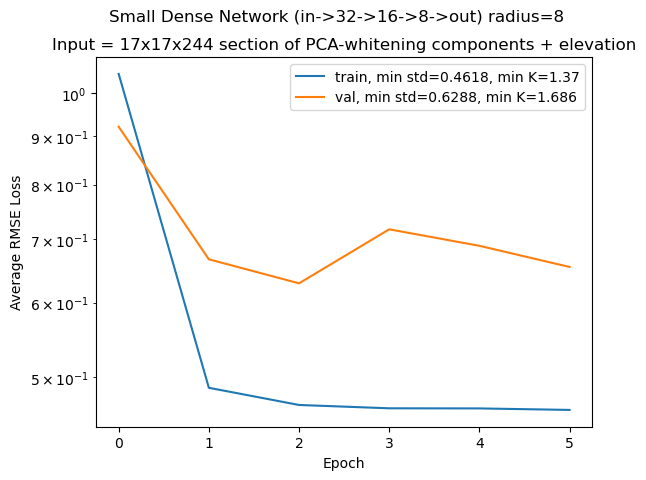

radius=10, n_components=16
 LinearModel(
  (linear_output): Linear(in_features=7497, out_features=1, bias=True)
)
Epoch 000:     Train (RMSE, K):  0.87119,  2.5841   	 Val (RMSE, K):  0.84762,   2.272   	LR:  0.001	Time: 1.19e+02
Epoch 001:     Train (RMSE, K):  0.48548,  1.4401   	 Val (RMSE, K):  0.72007,  1.9301   	LR:  0.001	Time: 1.21e+02
Epoch 002:     Train (RMSE, K):  0.46358,  1.3751   	 Val (RMSE, K):  0.64852,  1.7383   	LR:  0.001	Time: 1.18e+02
Epoch 003:     Train (RMSE, K):  0.4621,  1.3707   	 Val (RMSE, K):  0.69915,   1.874   	LR:  0.001	Time: 1.19e+02
Epoch 004:     Train (RMSE, K):  0.46203,  1.3705   	 Val (RMSE, K):  0.69233,  1.8557   	LR:  0.001	Time: 1.2e+02
Epoch 005:     Train (RMSE, K):  0.45904,  1.3616   	 Val (RMSE, K):  0.77275,  2.0713   	LR:  0.001	Time: 1.22e+02


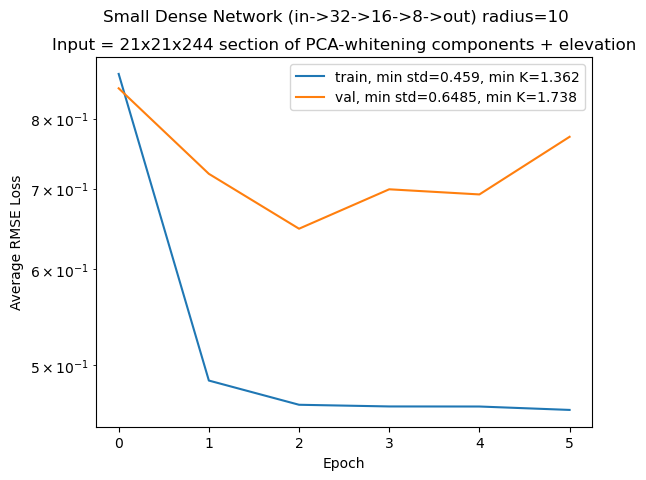

radius=12, n_components=16
 LinearModel(
  (linear_output): Linear(in_features=10625, out_features=1, bias=True)
)
Epoch 000:     Train (RMSE, K):  0.97543,  2.8934   	 Val (RMSE, K):  0.91064,  2.4409   	LR:  0.001	Time: 1.5e+02
Epoch 001:     Train (RMSE, K):  0.48311,   1.433   	 Val (RMSE, K):  0.71113,  1.9061   	LR:  0.001	Time: 1.68e+02
Epoch 002:     Train (RMSE, K):  0.46375,  1.3756   	 Val (RMSE, K):  0.78597,  2.1067   	LR:  0.001	Time: 1.54e+02
Epoch 003:     Train (RMSE, K):  0.46068,  1.3665   	 Val (RMSE, K):  0.73437,  1.9684   	LR:  0.001	Time: 1.57e+02
Epoch 004:     Train (RMSE, K):  0.4585,    1.36   	 Val (RMSE, K):  0.70833,  1.8986   	LR:  0.001	Time: 1.53e+02
Epoch 005:     Train (RMSE, K):  0.45809,  1.3588   	 Val (RMSE, K):  0.80134,  2.1479   	LR:  0.001	Time: 1.51e+02


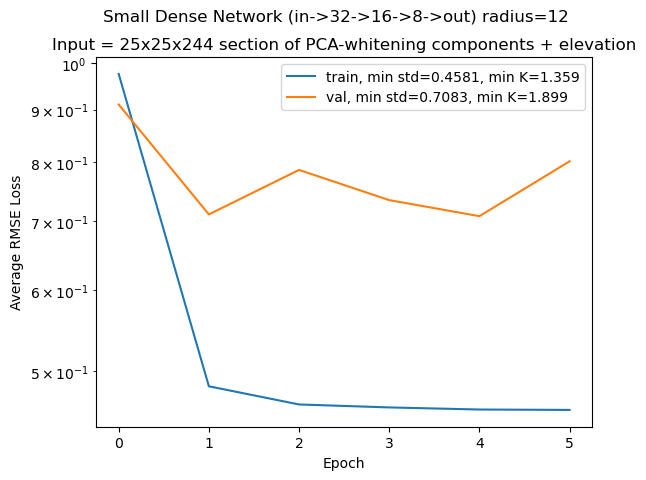

radius=16, n_components=16
 LinearModel(
  (linear_output): Linear(in_features=18513, out_features=1, bias=True)
)
Epoch 000:     Train (RMSE, K):  0.80759,  2.3955   	 Val (RMSE, K):  0.91601,  2.4553   	LR:  0.001	Time: 2.19e+02
Epoch 001:     Train (RMSE, K):  0.50683,  1.5034   	 Val (RMSE, K):  0.79138,  2.1212   	LR:  0.001	Time: 2.16e+02


In [21]:
importlib.reload(datasets.Datasets)
importlib.reload(models.Feedforward)
importlib.reload(utils.train)
importlib.reload(utils.eval)

batch_size = 256
val_batch_size = 1024

n_epochs = 5
dropout_rate = 0.0

stats_list = []
train_loss_array_list = []
val_loss_array_list = []
train_loss_list = []
val_loss_list = []

stats = None
print('Start Training', file=open(log_file_path, 'w'))
try:
    for combo in benchmark_combos:
        radius, n = combo

        omit_components = 0 # 244 - n

        # create datasets and dataloaders

        train_dataset = datasets.Datasets.PatchToPixelDataset(
            emit_data=emit_train,
            omit_components=omit_components,
            ecostress_data=eco_train,
            ecostress_center=None,
            ecostress_scale=None,
            additional_data=(elev_train,),
            radius=radius,
            boundary_width=max(
                [benchmark_combos[i][0] for i in range(len(benchmark_combos))]
            ),
        )

        val_dataset = datasets.Datasets.PatchToPixelDataset(
            emit_data=emit_val,
            omit_components=omit_components,
            ecostress_data=eco_val,
            ecostress_center=None,
            ecostress_scale=None,
            additional_data=(elev_val,),
            radius=radius,
            boundary_width=max(
                [benchmark_combos[i][0] for i in range(len(benchmark_combos))]
            ),
        )

        if batch_size is not None:
            train_loader = DataLoader(
                dataset=train_dataset,
                batch_size=batch_size,
                drop_last=False,
                shuffle=True,
            )
            val_loader = DataLoader(
                dataset=val_dataset,
                batch_size=val_batch_size,
                drop_last=False,
                shuffle=False,
            )
        else:
            train_loader = DataLoader(
                dataset=train_dataset, batch_size=batch_size, shuffle=True,
            )
            val_loader = DataLoader(
                dataset=val_dataset, batch_size=batch_size, shuffle=False,
            )
            
        
        model = models.Feedforward.LinearModel(
            input_dim=train_dataset.input_dim,
            radius=radius,
            dropout_rate=dropout_rate,
        )
        
        if device == 'cuda':
            model = model.cuda()

        optimizer = optim.Adam(
            params=model.parameters(), lr=0.001, weight_decay=0, fused=True
        )

        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer, factor=0.2, patience=2
        )

        loss_fn = nn.MSELoss(reduction='sum')

        print(f'radius={combo[0]}, n_components={combo[1]}\n', model)
        print(
            f'radius={combo[0]}, n_components={combo[1]}\n',
            model,
            file=open(log_file_path, 'a'),
        )
        
        train_loss, val_loss, eval_stats, train_loss_array, val_loss_array = (
            utils.train.train(
                model,
                optimizer,
                scheduler,
                loss_fn,
                train_loader,
                val_loader,
                n_epochs=n_epochs,
                loss_interval=1,
                # preexisting_losses=[train_loss, val_loss],
                device=device,
                log_file_path=log_file_path,
            )
        )
        
        eval_stats = np.concatenate([np.array(combo), eval_stats])
        stats_list.append(eval_stats)
        train_loss_array_list.append(train_loss_array)
        val_loss_array_list.append(val_loss_array)
        train_loss_list.append(train_loss)
        val_loss_array_list.append(val_loss)
        
        
        fig, ax = plt.subplots()
        fig.suptitle(
            f'Small Dense Network (in->32->16->8->out) radius={radius}'
        )
        l = 2 * radius + 1
        ax.set_title(
            f'Input = {l}x{l}x{244 - omit_components} section of '
            'PCA-whitening components + elevation'
        )
        ax.semilogy(
            np.arange(len(train_loss)),
            train_loss,
            label=(
                'train, '
                f'min std={min(train_loss):.4}, '
                f'min K={train_dataset.ecostress_scale * min(train_loss):.4}'
            ),
        )
        ax.semilogy(
            np.arange(len(val_loss)),
            val_loss,
            label=(
                'val, '
                f'min std={min(val_loss):.4}, '
                f'min K={val_dataset.ecostress_scale * min(val_loss):.4}'
            ),
        )
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Average RMSE Loss')
        ax.legend()
        plt.show(fig)
        
        torch.save(
            model.state_dict(),
            join_path(f'Data\\Models\\linear_r{radius}_n{n}.pt')
        )
        
    stats = np.array(stats_list)
    stats_columns = utils.eval.initialize_eval_results().columns.to_list()
    stats = pd.DataFrame(stats, columns=stats_columns)
    stats['radius'] = stats['radius'].astype(int)
    stats['n_components'] = stats['n_components'].astype(int)
        
except KeyboardInterrupt:
    print('Training was interrupted by user')
    print('Training was interrupted by user', file=open(log_file_path, 'a'))

stats

In [18]:
stats.to_csv(join_path(r'Miscellaneous\linear_benchmarking_ae_temp16r.csv'))

In [36]:
stats.iloc[:,35].min(), stats.loc[:, 'val_std_99.5pct'].min(), stats.loc[:, 'val_std_99.5pct'].argmin()

(0.7758370370773048, 2.623185461591357, 0)

In [19]:
stats.columns

Index(['radius', 'n_components', 'train_avg_std', 'train_std_std',
       'train_std_min', 'train_std_0.5pct', 'train_std_2.5pct',
       'train_std_16pct', 'train_std_25pct', 'train_std_50pct',
       'train_std_75pct', 'train_std_84pct', 'train_std_97.5pct',
       'train_std_99.5pct', 'train_std_max', 'train_avg_K', 'train_std_K',
       'train_K_min', 'train_K_0.5pct', 'train_K_2.5pct', 'train_K_16pct',
       'train_K_25pct', 'train_K_50pct', 'train_K_75pct', 'train_K_84pct',
       'train_K_97.5pct', 'train_K_99.5pct', 'train_K_max', 'val_avg_std',
       'val_std_std', 'val_std_min', 'val_std_0.5pct', 'val_std_2.5pct',
       'val_std_16pct', 'val_std_25pct', 'val_std_50pct', 'val_std_75pct',
       'val_std_84pct', 'val_std_97.5pct', 'val_std_99.5pct', 'val_std_max',
       'val_avg_K', 'val_std_K', 'val_K_min', 'val_K_0.5pct', 'val_K_2.5pct',
       'val_K_16pct', 'val_K_25pct', 'val_K_50pct', 'val_K_75pct',
       'val_K_84pct', 'val_K_97.5pct', 'val_K_99.5pct', 'val_K_max'],

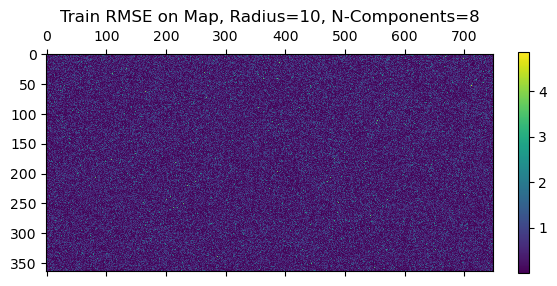

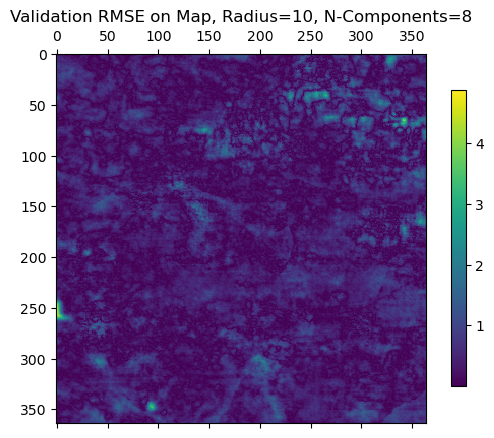

In [25]:
fig, ax = plt.subplots()
ax.set_title('Train RMSE on Map, Radius=10, N-Components=8')
plt.imshow(train_loss_array)
plt.colorbar(fraction=0.05, shrink=0.6)
ax.matshow(train_loss_array)
plt.show(fig)
fig, ax = plt.subplots()
ax.set_title('Validation RMSE on Map, Radius=10, N-Components=8')
plt.imshow(train_loss_array)
plt.colorbar(fraction=0.05, shrink=0.8)
ax.matshow(val_loss_array)
plt.show(fig)

In [ ]:
n_components_benchmark_radii = [0]
#[0, 1, 3, 8, 16]
n_components_benchmark_n_components = [1, 2, 3, 4, 5, 8, 10, 12, 16,]
#[1, 2, 3, 4, 8, 16, 32, 64, 128, 244]

radius_benchmark_radii = []#[0, 1, 2, 3, 4, 8, 16]
radius_benchmark_n_components = []#[8, 16, 32, 64, 244]

benchmark_combos = []
for radius in n_components_benchmark_radii:
    for n in n_components_benchmark_n_components:
        benchmark_combos.append((radius, n))

for radius in radius_benchmark_radii:
    for n in radius_benchmark_n_components:
        if (radius, n) in benchmark_combos:
            continue
        else:
            benchmark_combos.append((radius, n))

len(benchmark_combos)

1